In [149]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

### 1) Reading in data
`df_labels` = Dataset containing the labels

`data_list` = Dataset containing the raw data of measurements

In [150]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

In [151]:
df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line all gas a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

# Optionally pretty-print the first JSON object for readability
# if data_list:
#     formatted_data = json.dumps(data_list[0], indent=4)
#     print(formatted_data)

In [152]:
print("### Info on Labelled Data ###")
print(f"There are {len(df_labels)} rows of data")
print(df_labels[0:5])

### Info on Labelled Data ###
There are 121838 rows of data
           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [153]:
print("### Info on Raw Data ###")
print(f"There are {len(data_list)} rows of data")
print("Breakdown of each record as follows: \n")
for dat in data_list[0:2]:
    print("Start of record:")
    for _,pos in dat.items():
        print(f"Gene ID: {_}")
        for _,seq in pos.items():
            print(f"Position: {_}")
            for _, measurements in seq.items():
                print(f"DNA Seq: {_}")
                print(f"Measurements: {measurements} \n") # List of 9 measurements: dwelling time, standard_dev, mean current at positions -1, 0, +1

### Info on Raw Data ###
There are 121838 rows of data
Breakdown of each record as follows: 

Start of record:
Gene ID: ENST00000000233
Position: 244
DNA Seq: AAGACCA
Measurements: [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1], [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9], [0.00465, 3.92, 109.0, 0.0136, 12.0, 124.0, 0.00498, 2.13, 79.6], [0.00398, 2.06, 125.0, 0.0083, 5.01, 130.0, 0.00498, 3.78, 80.4], [0.00664, 2.92, 120.0, 0.00266, 3.94, 129.0, 0.013, 7.15, 82.2], [0.0103, 3.83, 123.0, 0.00598, 6.45, 126.0, 0.0153, 1.09, 74.8], [0.00398, 3.75, 126.0, 0.00332, 4.3, 129.0, 0.00299, 1.93, 81.9], [0.00498, 3.93, 127.0, 0.00398, 2.51, 131.0, 0.0111, 3.47, 79.4], [0.0139, 4.69, 106.0, 0.0136, 6.21, 124.0, 0.00531, 10.6, 85.5], [0.00631, 3.5, 126.0, 0.0222, 5.38, 128.0, 0.00332, 1.72, 79.3], [0.0061, 3.99, 121.0, 0.0121, 7.27, 122.0, 0.00232, 1.27, 78.9], [0.00299, 1.99, 128.0, 0.00427, 4.85, 124.0, 0.00332, 3.18, 80.5], [0.0186, 3.62, 124.0, 0.00428, 2

In [154]:
unique_gene_ids = df_labels['gene_id'].nunique()
unique_transcript_ids = df_labels['transcript_id'].nunique()

label_counts = df_labels['label'].value_counts()

print(f"Unique gene IDs: {unique_gene_ids}")
print(f"Unique transcript IDs: {unique_transcript_ids} \n")
print("Breakdown of label counts:")
print(label_counts)

Unique gene IDs: 3852
Unique transcript IDs: 5333 

Breakdown of label counts:
label
0    116363
1      5475
Name: count, dtype: int64


Distribution of number of times same gene ID is repeated in the dataset:


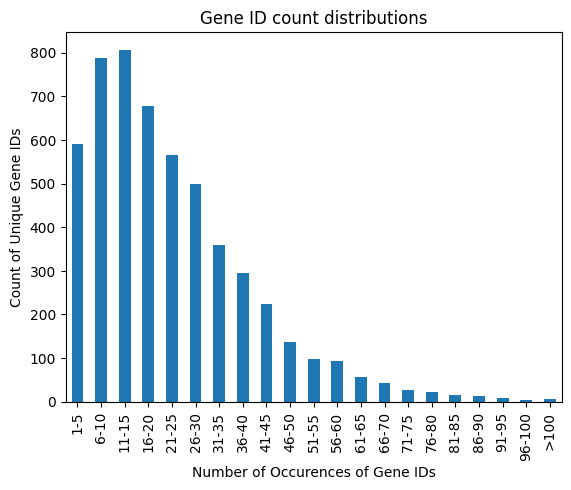

In [155]:
print("Distribution of number of times same gene ID is repeated in the dataset:")
gene_counts = df_labels.groupby('transcript_id').size()
bins = list(range(0, 105, 5)) + [float('inf')]  # [0, 5, 10, ..., 50, inf]
bin_labels = [f'{bins[i-1]+1}-{bins[i]}' for i in range(1, len(bins)-1)] + ['>100']
gene_bins = pd.cut(gene_counts, bins=bins, labels=bin_labels, right=True)
bin_summary = gene_bins.value_counts().sort_index()
bin_summary.plot(kind='bar')
plt.title('Gene ID count distributions')
plt.xlabel('Number of Occurences of Gene IDs')
plt.ylabel("Count of Unique Gene IDs")
plt.show()

def transcript_distribution():
    """
    Function to generate the plot showing the distribution of transcript IDs in gene IDs
        Take note: transcript IDs are not found in the raw training data so this may not be as useful
    """
    transcript_counts = df_labels.groupby('gene_id')['transcript_id'].nunique()
    bin_labels = ['1', '2-3', '>=4']
    bins = [0, 1, 3, float('inf')]
    transcript_bins = pd.cut(transcript_counts, bins=bins, labels=bin_labels, right=True)
    bin_summary = transcript_bins.value_counts().sort_index()
    bin_summary.plot(kind='bar')
    plt.title('Gene ID Count by Number of Unique Transcript IDs')
    plt.xlabel('Number of Unique Transcript IDs')
    plt.ylabel('Count of Gene IDs')
    plt.show()

# transcript_distribution()

In [192]:
# mapping for sequence
mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
def one_hot_encode(seq):
    return np.array([mapping[nuc] for nuc in seq]).flatten()
# aggregating data_list
def create_aggregated_dataframe(data_list):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)

                    # Method to calculate deviation amongst the X number of measurements and take the top 20th that do not deviate
                    def calculate_deviation(obj):
                        # Extract standard deviations for each position (-1, 0, +1)
                        dwell_time = [obj[0], obj[3], obj[6]]
                        std_devs = [obj[1], obj[4], obj[7]]  # Indices of standard deviations
                        means = [obj[2], obj[5], obj[8]]  

                        std_dev_mean = np.var(std_devs)
                        
                        # Example metric: variance across the mean readings for all positions
                        mean_variance = np.var(means)

                        # Deviation metric: sum of std deviation mean and variance of means
                        deviation_score = std_dev_mean + mean_variance

                        return deviation_score

                    # Step 1: Calculate deviation scores for all objects
                    # deviation_scores = np.array([calculate_deviation(obj) for obj in scores_array])

                    # most_normal_indices = np.argsort(deviation_scores)[:20]

                    # Step 3: Extract the 20 most normal objects
                    # scores_array = scores_array[most_normal_indices]
                    
                    # Calculate the mean, sum, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    sum_scores = np.sum(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)

                    encoded_seq = one_hot_encode(sequence)
                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position
                    }
                    for idx, value in enumerate(encoded_seq):
                        transcript_position[f'encoded_{idx}'] = value
                    
                    for idx in range(scores_array.shape[1]): 

                        transcript_position.update({
                            f'mean {idx}': mean_scores[idx],
                            #f'sum {idx}': sum_scores[idx],
                            #f'max {idx}': max_scores[idx],
                            #f'min {idx}': min_scores[idx]
                        })
                    rows.append(transcript_position)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list)

In [193]:
print(aggregated_df[0:5])

     transcript_id transcript_position  encoded_0  encoded_1  encoded_2  \
0  ENST00000000233                 244          1          0          0   
1  ENST00000000233                 261          0          1          0   
2  ENST00000000233                 316          0          0          1   
3  ENST00000000233                 332          1          0          0   
4  ENST00000000233                 368          1          0          0   

   encoded_3  encoded_4  encoded_5  encoded_6  encoded_7  ...  encoded_27  \
0          0          1          0          0          0  ...           0   
1          0          1          0          0          0  ...           0   
2          0          1          0          0          0  ...           0   
3          0          0          0          1          0  ...           1   
4          0          0          0          1          0  ...           0   

     mean 0    mean 1      mean 2    mean 3    mean 4      mean 5    mean 6  \
0  0.00

In [194]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)
df_full = pd.merge(aggregated_df, df_labels[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

df_zero = df_full[df_full['label'] == 0]
df_mutations = df_full[df_full['label'] == 1]

df_full_zero = df_zero.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 1), random_state=42))

df_full = pd.concat([df_mutations, df_full_zero], axis = 0)
df_full_test = pd.concat([df_mutations, df_zero], axis = 0).reset_index(drop=True)
df_full_test_working = df_full_test.copy()
# Reset the index to avoid hierarchical indexing after using apply
df_full = df_full.reset_index(drop=True)
print(df_full)
print(df_full['label'].value_counts())


         transcript_id  transcript_position  encoded_0  encoded_1  encoded_2  \
0      ENST00000000233                  913          0          0          1   
1      ENST00000000412                 2440          0          0          0   
2      ENST00000000412                 2462          0          0          0   
3      ENST00000000412                 2499          0          0          0   
4      ENST00000007390                 1096          0          0          1   
...                ...                  ...        ...        ...        ...   
10792  ENST00000641375                 1586          0          0          0   
10793  ENST00000641390                 1806          0          1          0   
10794  ENST00000641708                  745          1          0          0   
10795  ENST00000641784                 2338          0          1          0   
10796  ENST00000641834                 1537          0          1          0   

       encoded_3  encoded_4  encoded_5 

C:\Users\chewy\AppData\Local\Temp\ipykernel_19752\1213463968.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full_zero = df_zero.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 1), random_state=42))


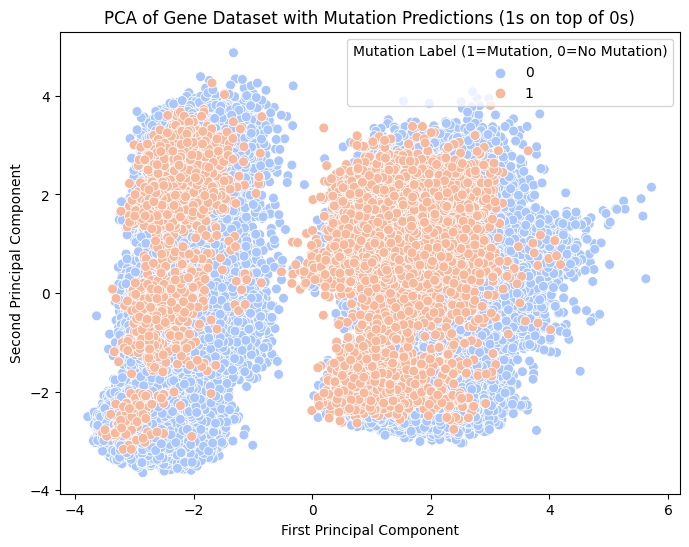

In [195]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_labels is the dataset you're working with, and it contains a 'label' column

# Step 1: Drop unnecessary columns (like transcript_id and transcript_position)
df_processed = df_full_test_working.drop(['transcript_id', 'transcript_position'], axis=1)

# Ensure that 'label' is retained for later use
labels = df_processed['label'].copy()

# Step 2: Normalize the data (if numerical), excluding the label
features = df_processed.drop('label', axis=1)  # Keep the label column for coloring
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

# Step 3: Apply PCA for dimensionality reduction (to 2D for visualization)
pca = PCA(n_components=2)  # Reduce to 2D for visualization purposes
df_pca = pca.fit_transform(df_scaled)

# Step 4: Combine PCA results and labels into a single DataFrame for easier manipulation
df_pca_labeled = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca_labeled['label'] = labels.values

# Step 5: Sort the data so that label=1 points are plotted after label=0 points
df_pca_labeled_sorted = df_pca_labeled.sort_values(by='label')

# Step 6: Visualize the first two PCA components, ensuring that 1s are plotted over 0s
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_pca_labeled_sorted, palette='coolwarm', s=50)
plt.title('PCA of Gene Dataset with Mutation Predictions (1s on top of 0s)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title="Mutation Label (1=Mutation, 0=No Mutation)")
plt.show()


In [188]:
df_full['label'] = df_full['label'].fillna(0)

In [196]:
df_working = df_full.copy()

x = df_working.drop(columns=['transcript_id', 'transcript_position','label'], axis=1)
y = df_full['label']

X = df_full_test_working.drop(columns=['transcript_id', 'transcript_position','label'], axis=1)
Y = df_full_test['label']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.2, random_state=42)

BASELINE MODELS

In [198]:
# optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

In [199]:
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred2 = model.predict(X_test2_scaled)

In [200]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

# Random Forest Baseline

accuracy = accuracy_score(y_test2, y_pred2)
roc_auc = roc_auc_score(y_test2, y_pred2)
report = classification_report(y_test2, y_pred2)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.8282407407407407
ROC AUC: 0.8281852685618591
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1052
           1       0.83      0.83      0.83      1108

    accuracy                           0.83      2160
   macro avg       0.83      0.83      0.83      2160
weighted avg       0.83      0.83      0.83      2160

Accuracy: 0.8832074852265266
ROC AUC: 0.8366973330112272
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     23231
           1       0.26      0.79      0.39      1137

    accuracy                           0.88     24368
   macro avg       0.62      0.84      0.66     24368
weighted avg       0.95      0.88      0.91     24368



XGBoost classifier

In [201]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred2 = model.predict(X_test2_scaled)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [202]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

# XGBoost baseline

accuracy = accuracy_score(y_test2, y_pred2)
roc_auc = roc_auc_score(y_test2, y_pred2)
report = classification_report(y_test2, y_pred2)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)


Accuracy: 0.8226851851851852
ROC AUC: 0.8225779330414132
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1052
           1       0.83      0.83      0.83      1108

    accuracy                           0.82      2160
   macro avg       0.82      0.82      0.82      2160
weighted avg       0.82      0.82      0.82      2160

Accuracy: 0.6534799737360473
ROC AUC: 0.7383780058846097
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     23231
           1       0.10      0.83      0.18      1137

    accuracy                           0.65     24368
   macro avg       0.55      0.74      0.48     24368
weighted avg       0.95      0.65      0.75     24368



In [171]:
print(y_test.value_counts())
print(y_train.value_counts())

print(y_test2.value_counts())

label
1    1108
0    1052
Name: count, dtype: int64
label
1    4367
0    4270
Name: count, dtype: int64
label
0    23231
1     1137
Name: count, dtype: int64
